## Name  : Anchit Gupta
## Roll no: MT19060

https://www.kaggle.com/himanshupoddar/zomato-bangalore-restaurants

In [1]:
%config IPCompleter.greedy=True

In [2]:
import sys
print(sys.executable)

/Users/apple/opt/anaconda3/bin/python


In [3]:
# Libraries used
import string
import pandas as pd
import numpy as np
import pandas_profiling as pp
from IPython.core.display import display, HTML
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score,f1_score, recall_score
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
%matplotlib inline
tqdm().pandas()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
src_file = "../dataset/zomato.csv"
data = pd.read_csv(src_file)

In [5]:
display(HTML('<h1>Columns data type</h1>'))
data_columns = data.columns.tolist()
for i in data_columns:
    print(i," : ",  data[i].dtype)

url  :  object
address  :  object
name  :  object
online_order  :  object
book_table  :  object
rate  :  object
votes  :  int64
phone  :  object
location  :  object
rest_type  :  object
dish_liked  :  object
cuisines  :  object
approx_cost(for two people)  :  object
reviews_list  :  object
menu_item  :  object
listed_in(type)  :  object
listed_in(city)  :  object


In [6]:
# Renaming the column values
column_name = {'usl':'url', 
               'address':'address',
               'name':'name',  
               'online_order':'netorder',
               'book_table':'booktable', 
               'rate':'rating',
               'votes':'votes', 
               'phone':'phone', 
               'location':'location', 
               'rest_type':'resttype', 
               'dish_liked':'dishliked', 
               'cuisines':'cuisines', 
               'approx_cost(for two people)':'cost', 
               'reviews_list':'reviews', 
               'menu_item':'menuitems', 
               'listed_in(type)':'listedin', 
               'listed_in(city)':'city'}

In [7]:
data  = data.rename(columns= column_name)

In [8]:
display(HTML('<h1>Percentage of Null Values</h1>'))
data.isnull().sum()*100/data.shape[0]

url           0.000000
address       0.000000
name          0.000000
netorder      0.000000
booktable     0.000000
rating       15.033741
votes         0.000000
phone         2.335789
location      0.040606
resttype      0.438927
dishliked    54.291626
cuisines      0.087012
cost          0.669026
reviews       0.000000
menuitems     0.000000
listedin      0.000000
city          0.000000
dtype: float64

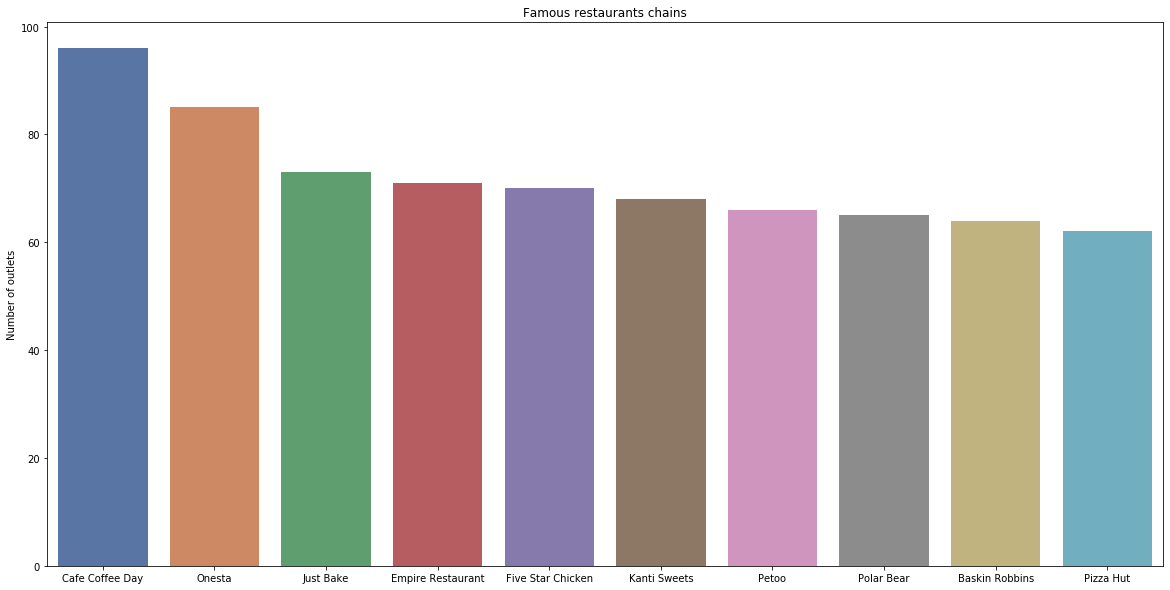

In [9]:
plt.figure(figsize=(20,10))
outlets = data['name'].value_counts()[:10]
sns.barplot(x = outlets.index, y = outlets, palette='deep')
plt.title("Famous restaurants chains")
plt.ylabel("Number of outlets")
plt.show()

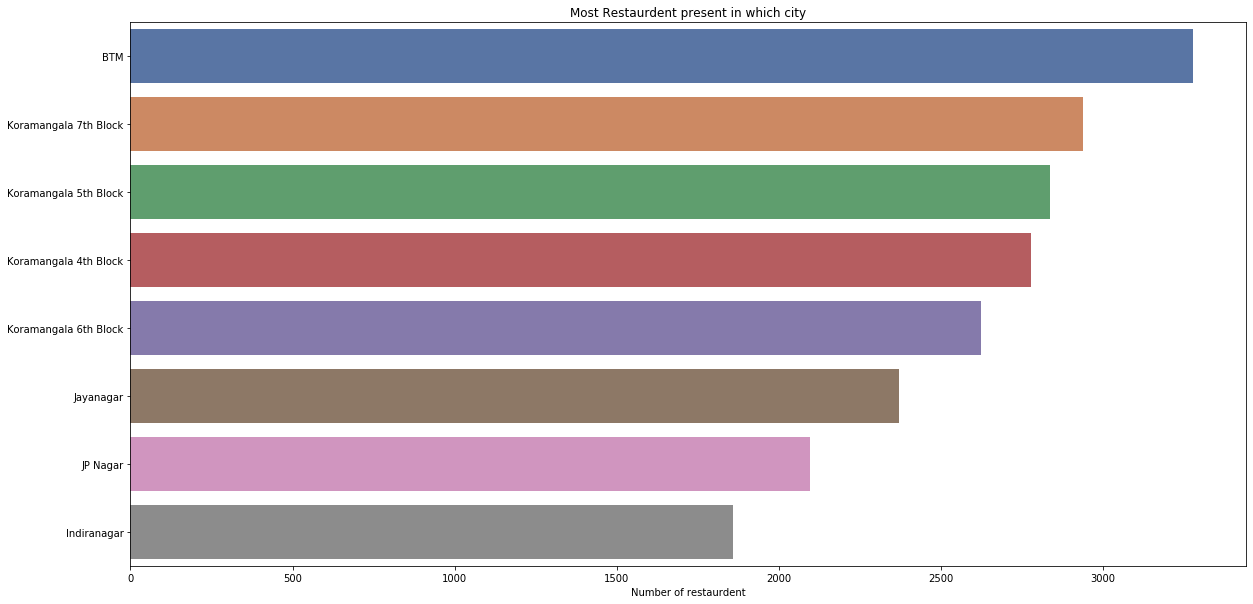

In [10]:
plt.figure(figsize=(20,10))
outlets = data['city'].value_counts()[:8]
sns.barplot(y = outlets.index, x = outlets, palette='deep')
plt.title("Most Restaurdent present in which city")
plt.xlabel("Number of restaurdent")
plt.show()

### Here Items are pruned on basis that usability and necessity to contribute in analysis

In [11]:
prune_items = ['url', 'address', 'name', 'phone', 'location',  'dishliked', 'menuitems']
data =  data.drop(prune_items, axis=1)

In [12]:
# Removing the rating
data.rating = data.rating.str[:3]

In [13]:
# Storing the data temporary
df = data[:]

### Function to fill empty rating values from the reviews by rating

In [14]:
def rating_is_null():
    reviews= {}
    null_brackets = []
    rating_null_index = df[df['rating'].isnull()].index.tolist()
    #print('null index: ', rating_null_index)
    for null_indexes in rating_null_index:
        temp_rev = df['reviews'][null_indexes]
        if temp_rev == '[]':
            null_brackets.append(null_indexes)
        elif type(temp_rev) == str:
            review_index = [i for i in range(len(temp_rev)) if temp_rev.startswith('(\'Rated ', i)]
            scores = [float(temp_rev[i+7:i+10]) for i in review_index]
            #print(np.mean(scores))
            df.loc[null_indexes, 'rating'] = round(np.mean(scores), 2)
    return null_brackets
    
    

In [15]:
rating_still_null = rating_is_null()

In [16]:
df['rating'] =  df['rating'].fillna(df['rating'].mode()[0])
df['rating'] =  df['rating'].replace( to_replace =['NEW', '-'], value =np.nan) 
df['rating'] =  df['rating'].astype(float)
df['rating'] =  pd.cut(df['rating'], 4, labels=[1,2,3,4])
df['rating'].unique()

[4, 3, 2, NaN, 1]
Categories (4, int64): [1 < 2 < 3 < 4]

In [17]:
df = df.dropna()
df = df.reset_index()

In [18]:
df['reviews'] = df['reviews'].replace(to_replace="[]", value=np.nan)
df = df.dropna()
df = df.reset_index()
df['reviews'].describe()

count                                                 42589
unique                                                21881
top       [('Rated 5.0', "RATED\n  This lobby cafe offer...
freq                                                     21
Name: reviews, dtype: object

In [19]:
df = df.drop(['level_0','index'], axis=1)

In [20]:
def getreview():
    sia = SentimentIntensityAnalyzer()
    stop = stopwords.words('english')
    pos = 0
    neg = 0
    neu = 0
    rscore = []
    for j in tqdm(df.index):
        r = df['reviews'].iloc[j]
        start = 0
        temp_rscore = []
        while r.find('RATED\\n  ', start)!= -1 and r is not np.nan:
            a = r.find('RATED\\n  ', start)
            b = r.find('\'),', a)
            text = r[a+9:b+1]
#             text = nltk.word_tokenize(text.lower())
            text = text.replace('\\n','')
            text = [word.strip(string.punctuation) for word in text.lower().split(' ')]
            text = [i.strip(string.punctuation) for i in text]
            text = [i for i in text if i not in stop and len(i)>1]
            text = [i for i in text if not any (c.isdigit() for c in i)]
            start = b
            temp_rscore.append(text)
        rscore.append(temp_rscore)
    return rscore
comments = getreview()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [21]:
def getinsight():
    # negative, neutral, positive
    ins_col = [[],[],[]]
    stop = stopwords.words('english')
    for comment in tqdm(comments):
        temp_rscore = []
        for text in comment:
            if len(text) != 0:
                score =  sia.polarity_scores(" ".join(text)) 
                if score['compound'] != 0:
                    l = [ score['neg'], score['neu'], score['pos']]
                    temp_rscore.append(l)
            else:
                pass
        temp_rscore = np.array(temp_rscore)
        mean_comment_score = np.mean(temp_rscore,axis=0)
        if type(mean_comment_score) == np.float64:
            ins_col[0].append(mean_comment_score)
            ins_col[1].append(mean_comment_score) 
            ins_col[2].append(mean_comment_score)
        else:
            ins_col[0].append(mean_comment_score[0])
            ins_col[1].append(mean_comment_score[1]) 
            ins_col[2].append(mean_comment_score[2])
    df_rev_neg = pd.DataFrame(ins_col[0]).rename(columns={0:'Rev_neg'})
    df_rev_neu = pd.DataFrame(ins_col[1]).rename(columns={0:'Rev_neu'})
    df_rev_pos = pd.DataFrame(ins_col[2]).rename(columns={0:'Rev_pos'})
    df_rev_neg = pd.merge(df_rev_neg, df_rev_neu, left_index=True, right_index=True)
    df_rev = pd.merge(df_rev_neg, df_rev_pos, left_index=True, right_index=True)
    return df_rev
df_rev = getinsight()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
df = pd.merge(df, df_rev, left_index=True, right_index=True)

In [23]:
df.head()

,netorder,booktable,rating,votes,resttype,cuisines,cost,reviews,listedin,city,Rev_neg,Rev_neu,Rev_pos
0,Yes,Yes,4,775,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Buffet,Banashankari,0.064000,0.596091,0.340091
1,Yes,No,4,787,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",Buffet,Banashankari,0.022571,0.628429,0.349000
2,Yes,No,3,918,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",Buffet,Banashankari,0.045667,0.673222,0.281222
3,No,No,3,88,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",Buffet,Banashankari,0.028125,0.699375,0.272708
4,No,No,3,166,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",Buffet,Banashankari,0.000000,0.766000,0.234000


In [24]:
df = df.drop(['reviews'], axis=1)
df = df.reset_index()

In [25]:
df = df.dropna()
# df = df.drop(['level_0','index'], axis=1)
df.isnull().sum()

index        0
netorder     0
booktable    0
rating       0
votes        0
resttype     0
cuisines     0
cost         0
listedin     0
city         0
Rev_neg      0
Rev_neu      0
Rev_pos      0
dtype: int64

In [26]:
# checkpoint data where reviews are addedc
df_temp = df[:]

### Creating asymmetric data of compound columns

In [27]:
def createSimpleColumns(c_name):
    restype_unique = df[c_name].unique().tolist()
    final_resttype = []
    for i in restype_unique:
        if(i.find(',') != -1):
            temp = i.split(',')
            for j in temp:
                final_resttype.append(j.strip().replace(" ", "_"))
        else:
            final_resttype.append(i.strip().replace(" ", "_"))
            
    final_resttype = list(frozenset(final_resttype))
    restype_datalist = df[c_name].tolist()
    df_resttype = pd.DataFrame(0, index=np.arange(len(restype_datalist)),columns=final_resttype)
    c = 0

    for i in tqdm(restype_datalist):
        k = []
        if (i.find(',') != -1):
            temp = i.split(',')
            for j in temp:
                j = j.strip()
                k.append(j)
        else:
            k.append(i.strip())
        df_resttype.loc[c] = np.isin(final_resttype, k).astype(int)
        c+=1
    return df_resttype, final_resttype

In [28]:
df_resttype,list_resttype = createSimpleColumns('resttype')
df_cuisines, list_cuisines = createSimpleColumns('cuisines')
df_resttype.rename(columns={'Cafe':'Rest_Cafe', 'Bakery':'Rest_Bakery'}, inplace=True)
d_res_cus = pd.merge(df_resttype, df_cuisines, left_index=True, right_index=True)
df = pd.merge(df, d_res_cus, left_index=True, right_index=True)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [29]:
df.head()

,index,netorder,booktable,rating,votes,resttype,cuisines,cost,listedin,city,...,Steak,Sushi,Momos,Seafood,German,Salad,British,Hyderabadi,European,Italian
0,0,Yes,Yes,4,775,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet,Banashankari,...,0,0,0,0,0,0,0,0,0,0
1,1,Yes,No,4,787,Casual Dining,"Chinese, North Indian, Thai",800,Buffet,Banashankari,...,0,0,0,0,0,0,0,0,0,0
2,2,Yes,No,3,918,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet,Banashankari,...,0,0,0,0,0,0,0,0,0,1
3,3,No,No,3,88,Quick Bites,"South Indian, North Indian",300,Buffet,Banashankari,...,0,0,0,0,0,0,0,0,0,0
4,4,No,No,3,166,Casual Dining,"North Indian, Rajasthani",600,Buffet,Banashankari,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df  = df.drop('resttype', axis = 1)
df  = df.drop('cuisines', axis = 1)

In [31]:
# df  = df.drop(['level_0','index'], axis = 1)
df = df.drop('index', axis=1)

In [32]:
df['netorder']  = df['netorder'].replace(to_replace=['No', 'Yes'], value=[0, 1])
df['booktable'] = df['booktable'].replace(to_replace=['No', 'Yes'], value=[0, 1])

In [33]:
df.head()

,netorder,booktable,rating,votes,cost,listedin,city,Rev_neg,Rev_neu,Rev_pos,...,Steak,Sushi,Momos,Seafood,German,Salad,British,Hyderabadi,European,Italian
0,1,1,4,775,800,Buffet,Banashankari,0.064000,0.596091,0.340091,...,0,0,0,0,0,0,0,0,0,0
1,1,0,4,787,800,Buffet,Banashankari,0.022571,0.628429,0.349000,...,0,0,0,0,0,0,0,0,0,0
2,1,0,3,918,800,Buffet,Banashankari,0.045667,0.673222,0.281222,...,0,0,0,0,0,0,0,0,0,1
3,0,0,3,88,300,Buffet,Banashankari,0.028125,0.699375,0.272708,...,0,0,0,0,0,0,0,0,0,0
4,0,0,3,166,600,Buffet,Banashankari,0.000000,0.766000,0.234000,...,0,0,0,0,0,0,0,0,0,0


In [34]:
toonedata = df['listedin'].unique().tolist()
toonedata

['Buffet',
 'Cafes',
 'Delivery',
 'Desserts',
 'Dine-out',
 'Drinks & nightlife',
 'Pubs and bars']

In [35]:
df_listedin, list_listedin = createSimpleColumns('listedin')
df_city, list_city     = createSimpleColumns('city')
df          = pd.merge(df, df_listedin, left_index=True, right_index=True)
df          = pd.merge(df, df_city    , left_index=True, right_index=True)
df          = df.drop('city', axis=1)
df          = df.drop('listedin', axis=1)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


### Rearranging the columns

In [36]:
final_columns =  df.columns.tolist()[3:] +df.columns.tolist()[:3]
df = df[final_columns]

In [37]:
df.head()

,votes,cost,Rev_neg,Rev_neu,Rev_pos,Mess,Bar,Casual_Dining,Quick_Bites,Dhaba,...,Frazer_Town,JP_Nagar,Basavanagudi,Koramangala_5th_Block,BTM,Bellandur,Indiranagar,netorder,booktable,rating
0,775,800,0.064000,0.596091,0.340091,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,4
1,787,800,0.022571,0.628429,0.349000,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
2,918,800,0.045667,0.673222,0.281222,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3
3,88,300,0.028125,0.699375,0.272708,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,166,600,0.000000,0.766000,0.234000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


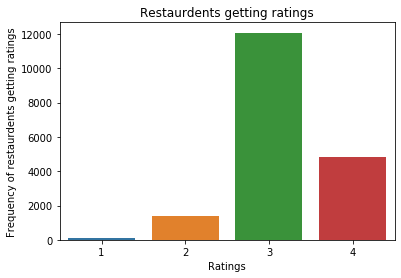

In [38]:
# plt.figure(figsize=(10,10))
outlets = df['rating'].value_counts()
sns.barplot(x = outlets.index, y = outlets)
plt.title("Restaurdents getting ratings")
plt.ylabel('Frequency of restaurdents getting ratings')
plt.xlabel('Ratings')
plt.show()

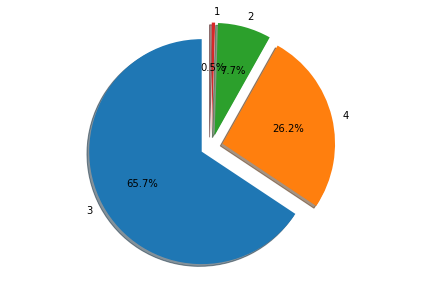

In [39]:

# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0.1, 0.1, 0.1, 0.1)
#add colors
fig1, ax1 = plt.subplots()
ax1.pie(outlets, explode=explode, labels=outlets.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.show()

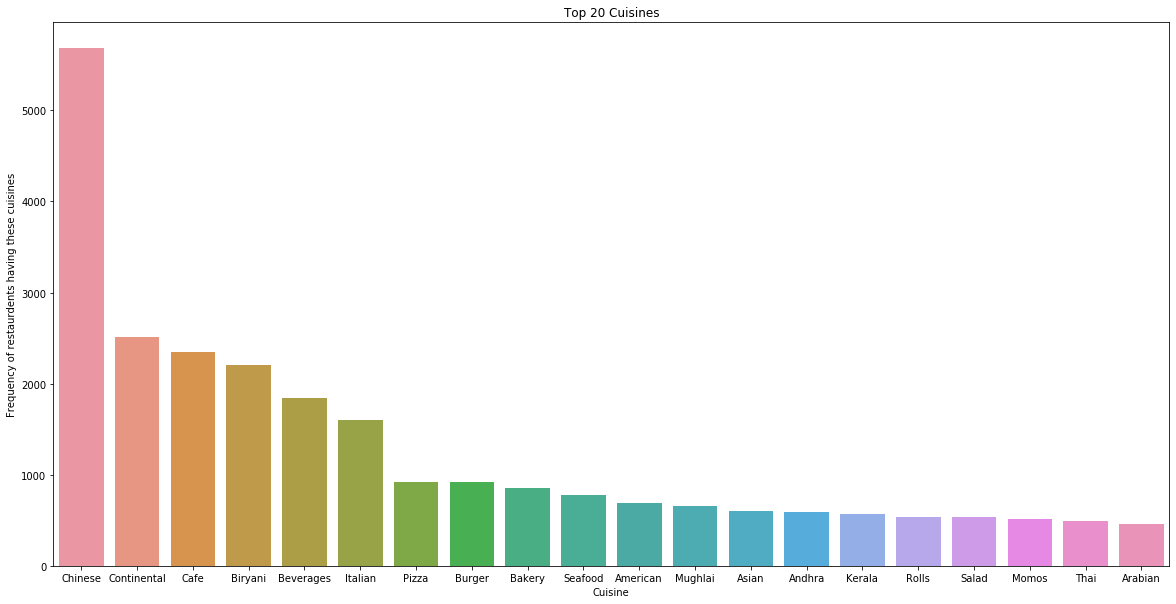

In [40]:
def topcuisine():
    k =[i for i in list_cuisines if i in df.columns]
    list_cuisines_top = {}
    for i in k:
        if df[i].value_counts()[0] != df.shape[0]:
            list_cuisines_top[i]=df[i].value_counts().tolist()[1]
    list_cuisines_top_sorted = sorted(list_cuisines_top.items(), key=lambda x:x[-1],reverse=True)
    plt.figure(figsize=(20,10))
    sns.barplot(x = [i[0] for i in list_cuisines_top_sorted[:20]], y = [i[1] for i in list_cuisines_top_sorted[:20]])
    plt.title("Top 20 Cuisines")
    plt.ylabel('Frequency of restaurdents having these cuisines')
    plt.xlabel('Cuisine')
    plt.show()

topcuisine()     

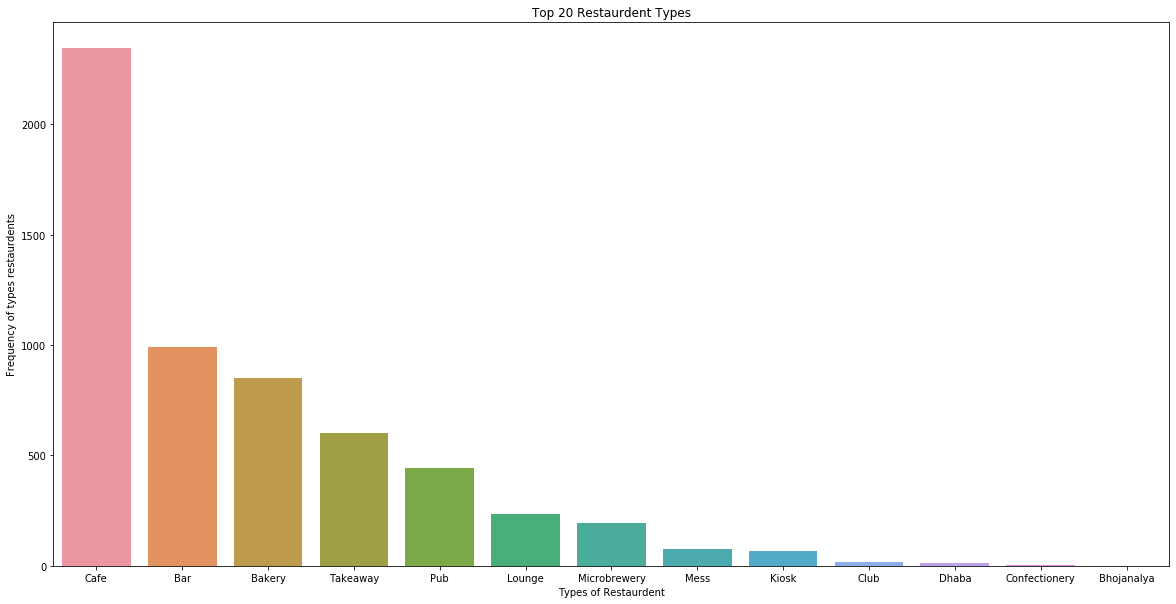

In [41]:
def topresttype():
    k =[i for i in list_resttype if i in df.columns]
    list_resttype_top = {}
    for i in k:
        if df[i].value_counts()[0] != df.shape[0]:
            list_resttype_top[i]=df[i].value_counts().tolist()[1]
    
    list_resttype_top_sorted = sorted(list_resttype_top.items(), key=lambda x:x[-1],reverse=True)
    list_top_rest = [i[0] for i in list_resttype_top_sorted[:20]]
    plt.figure(figsize=(20,10))
    sns.barplot(x = [i[0] for i in list_resttype_top_sorted[:20]], y = [i[1] for i in list_resttype_top_sorted[:20]])
    plt.title("Top 20 Restaurdent Types")
    plt.ylabel('Frequency of types restaurdents')
    plt.xlabel('Types of Restaurdent')
    plt.show()
    return list_top_rest

list_top_rest = topresttype() 

In [43]:
# def topresttopcity():
    
#     k =[i for i in list_city if i in df.columns]
#     list_city_top = {}
#     for i in k:
#         if df[i].value_counts()[0] != df.shape[0]:
#             list_city_top[i]=df[i].value_counts().tolist()[1]
#     list_city_top_sorted = sorted(list_city_top.items(), key=lambda x:x[-1],reverse=True)
#     top_city_name = [i[0] for i in list_city_top_sorted[:10]]
#     topresttopcity_data = []
    
#     matrix_city_rest = pd.DataFrame(index=top_city_name, columns=list_top_rest)
#     for i in top_city_name:
#         for j in list_top_rest:
#             l = [i,j]
#             d = df[l]
#             d = d.sum(axis=1).to_frame()
#             sup = (d[0] == 2).sum()
#             matrix_city_rest[j].loc[i] = sup
#             topresttopcity_data.append([i,j,sup])
#     plt.figure(figsize=(10,10))
#     plt.title("Top 10 Crowded cities having the top restuardent types")
#     print(matrix_city_rest)
#     sns.heatmap(matrix_city_rest, annot=True, fmt="g", cmap='viridis')
#     plt.show()
    
# topresttopcity()

In [44]:
df['rating'].value_counts()

3    12080
4     4820
2     1411
1       87
Name: rating, dtype: int64

<Figure size 720x216 with 0 Axes>

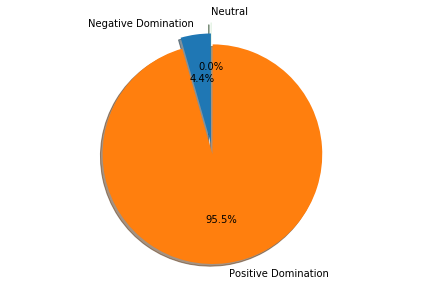

In [45]:
def reviewinsight():
    neg = len(np.where(df['Rev_neg'] >  df['Rev_pos'])[0])
    pos = len(np.where(df['Rev_neg'] <  df['Rev_pos'])[0])
    equ = len(np.where(df['Rev_neg'] == df['Rev_pos'])[0])
#     sns.catplot(x='Range', y='Range' , data =[neg, pos, equ], kind="bar",height=10, aspect=1.9, palette='coolwarm')
    plt.figure(figsize=(10,3))
#     sns.barplot(x=['Negative Domination','Positive Domination','Neutral'], y=[neg, pos,equ],  palette="Blues_d")
    explode = (0.0, 0.1, 0.1)
    #add colors
    fig1, ax1 = plt.subplots()
    ax1.pie([neg, pos,equ], explode=explode, labels=['Negative Domination','Positive Domination','Neutral'], autopct='%1.1f%%',shadow=True, startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')
    plt.tight_layout()
    plt.show()
    
reviewinsight()    

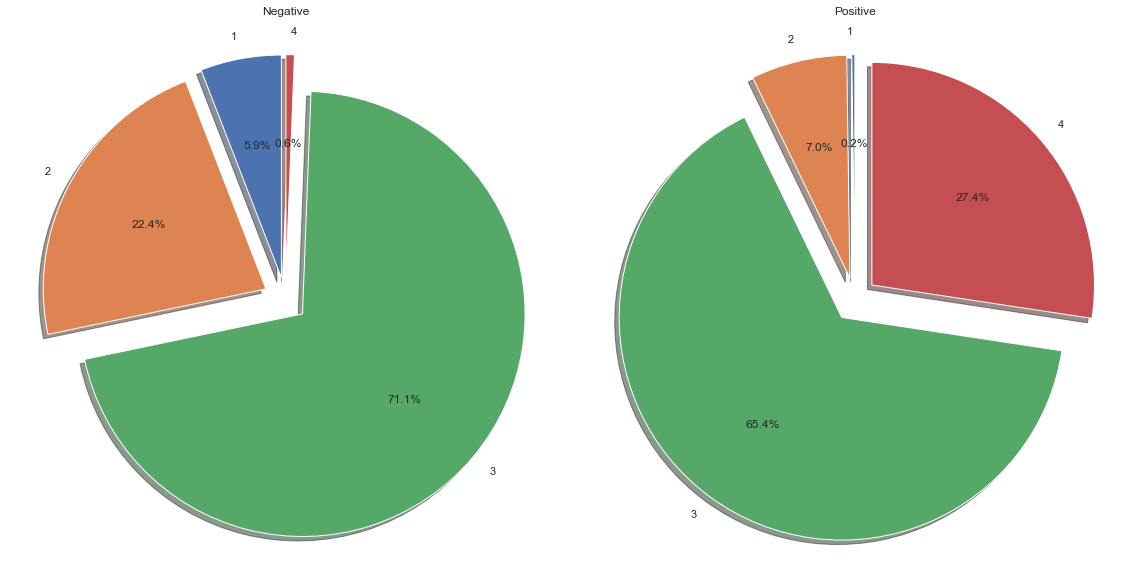

In [48]:
def reviewinsight2():
    
    
    neg_index  = np.where(df['Rev_neg'] >  df['Rev_pos'])[0]
    neg_index2 = np.where(df['Rev_neg'] <  df['Rev_pos'])[0]
    
    rating = []
    rating2 = []
    
    for i in neg_index:
        rating.append(df['rating'].iloc[i])
    for j in neg_index2:
        rating2.append(df['rating'].iloc[j])
        
    unique , counts  = np.unique(rating, return_counts=True)
    unique2, counts2 = np.unique(rating2, return_counts=True) 
   
    fig1, (ax1,ax2) = plt.subplots(1,2)
    
    ax1.title.set_text('Negative')
    ax1.pie(counts, explode=explode, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90)
    
    ax2.title.set_text('Positive')
    ax2.pie(counts2, explode=explode, labels=unique2, autopct='%1.1f%%',shadow=True, startangle=90)
    
#     ax1.axis('equal')
#     ax2.axis('equal')
    
    
    plt.tight_layout()
    plt.show()
    
    
        
reviewinsight2()

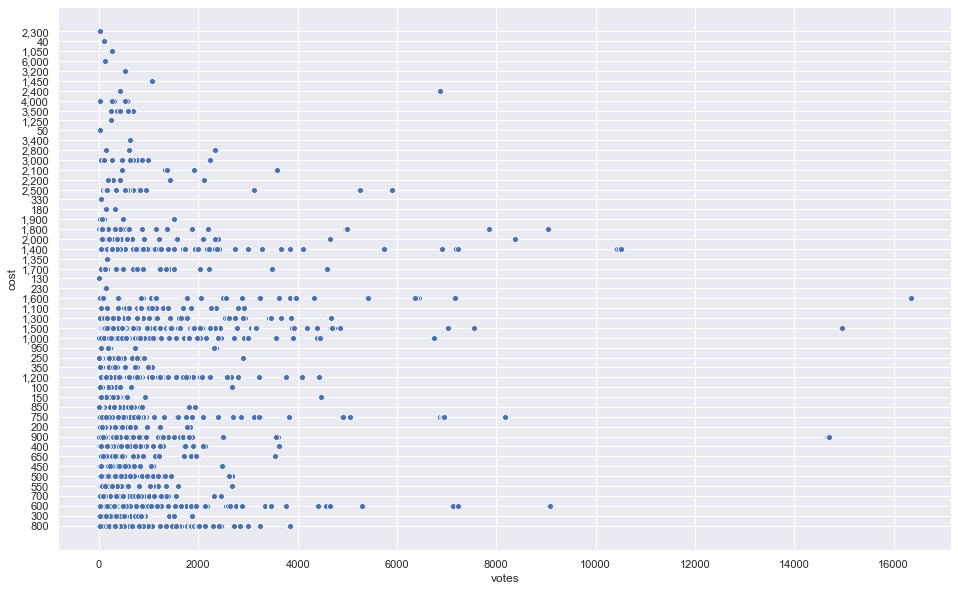

In [49]:
def lineplotseaborn():
    sns.set(rc={'figure.figsize':(16,10)})
    sns.scatterplot(x='votes' , y='cost' ,data=df)
lineplotseaborn()

In [50]:
df = df_temp2[:]

NameError: name 'df_temp2' is not defined

In [51]:
df_temp2 = df[:]

### Encoding the data

In [52]:
labelencoder   = LabelEncoder()

In [53]:
df = df.apply(labelencoder.fit_transform)

In [54]:
df2 = df[:]

In [55]:
#Using Pearson Correlation
corr = df.corr().abs()
corr

,votes,cost,Rev_neg,Rev_neu,Rev_pos,Mess,Bar,Casual_Dining,Quick_Bites,Dhaba,...,Frazer_Town,JP_Nagar,Basavanagudi,Koramangala_5th_Block,BTM,Bellandur,Indiranagar,netorder,booktable,rating
votes,1.000000,0.233538,0.090194,0.039558,0.048440,0.008153,0.016259,NaN,NaN,0.005273,...,NaN,NaN,0.020144,NaN,0.000680,0.023626,0.031110,0.034207,0.534186,0.523688
cost,0.233538,1.000000,0.064037,0.035207,0.067016,0.012826,0.007722,NaN,NaN,0.005746,...,NaN,NaN,0.022268,NaN,0.017300,0.002768,0.047908,0.166744,0.372206,0.193495
Rev_neg,0.090194,0.064037,1.000000,0.146564,0.314575,0.009411,0.006702,NaN,NaN,0.005510,...,NaN,NaN,0.003792,NaN,0.000985,0.018931,0.005762,0.034028,0.098262,0.261407
Rev_neu,0.039558,0.035207,0.146564,1.000000,0.823866,0.001603,0.007002,NaN,NaN,0.010677,...,NaN,NaN,0.008908,NaN,0.013780,0.021001,0.000463,0.014484,0.004133,0.032824
Rev_pos,0.048440,0.067016,0.314575,0.823866,1.000000,0.001692,0.006416,NaN,NaN,0.007917,...,NaN,NaN,0.010077,NaN,0.016487,0.009151,0.004425,0.030314,0.068205,0.147523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bellandur,0.023626,0.002768,0.018931,0.021001,0.009151,0.002271,0.010408,NaN,NaN,0.004626,...,NaN,NaN,0.032812,NaN,0.055092,1.000000,0.040265,0.014389,0.021390,0.005052
Indiranagar,0.031110,0.047908,0.005762,0.000463,0.004425,0.005228,0.033360,NaN,NaN,0.005681,...,NaN,NaN,0.040301,NaN,0.067666,0.040265,1.000000,0.097658,0.018764,0.039693
netorder,0.034207,0.166744,0.034028,0.014484,0.030314,0.003412,0.013514,NaN,NaN,0.001336,...,NaN,NaN,0.006796,NaN,0.015631,0.014389,0.097658,1.000000,0.045001,0.024517
booktable,0.534186,0.372206,0.098262,0.004133,0.068205,0.000788,0.019505,NaN,NaN,0.005960,...,NaN,NaN,0.016579,NaN,0.005221,0.021390,0.018764,0.045001,1.000000,0.398654


In [56]:
# to_drop = []
# for col in df.columns:
#     if np.isnan(corr[col].values).astype(int).sum() == df.shape[1] :
#         to_drop.append(col)
# to_drop

In [57]:
# df = df.drop(to_drop, axis=1)

In [58]:
corr = df.corr().abs()
corr

,votes,cost,Rev_neg,Rev_neu,Rev_pos,Mess,Bar,Casual_Dining,Quick_Bites,Dhaba,...,Frazer_Town,JP_Nagar,Basavanagudi,Koramangala_5th_Block,BTM,Bellandur,Indiranagar,netorder,booktable,rating
votes,1.000000,0.233538,0.090194,0.039558,0.048440,0.008153,0.016259,NaN,NaN,0.005273,...,NaN,NaN,0.020144,NaN,0.000680,0.023626,0.031110,0.034207,0.534186,0.523688
cost,0.233538,1.000000,0.064037,0.035207,0.067016,0.012826,0.007722,NaN,NaN,0.005746,...,NaN,NaN,0.022268,NaN,0.017300,0.002768,0.047908,0.166744,0.372206,0.193495
Rev_neg,0.090194,0.064037,1.000000,0.146564,0.314575,0.009411,0.006702,NaN,NaN,0.005510,...,NaN,NaN,0.003792,NaN,0.000985,0.018931,0.005762,0.034028,0.098262,0.261407
Rev_neu,0.039558,0.035207,0.146564,1.000000,0.823866,0.001603,0.007002,NaN,NaN,0.010677,...,NaN,NaN,0.008908,NaN,0.013780,0.021001,0.000463,0.014484,0.004133,0.032824
Rev_pos,0.048440,0.067016,0.314575,0.823866,1.000000,0.001692,0.006416,NaN,NaN,0.007917,...,NaN,NaN,0.010077,NaN,0.016487,0.009151,0.004425,0.030314,0.068205,0.147523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bellandur,0.023626,0.002768,0.018931,0.021001,0.009151,0.002271,0.010408,NaN,NaN,0.004626,...,NaN,NaN,0.032812,NaN,0.055092,1.000000,0.040265,0.014389,0.021390,0.005052
Indiranagar,0.031110,0.047908,0.005762,0.000463,0.004425,0.005228,0.033360,NaN,NaN,0.005681,...,NaN,NaN,0.040301,NaN,0.067666,0.040265,1.000000,0.097658,0.018764,0.039693
netorder,0.034207,0.166744,0.034028,0.014484,0.030314,0.003412,0.013514,NaN,NaN,0.001336,...,NaN,NaN,0.006796,NaN,0.015631,0.014389,0.097658,1.000000,0.045001,0.024517
booktable,0.534186,0.372206,0.098262,0.004133,0.068205,0.000788,0.019505,NaN,NaN,0.005960,...,NaN,NaN,0.016579,NaN,0.005221,0.021390,0.018764,0.045001,1.000000,0.398654


In [59]:
b_df = df[:]
cols = list(df)
feature_cols = cols[:len(cols)-1]
X = df[feature_cols] # Features
y = df.rating # Target variable

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [61]:

def drawranking(r, n, order=1):
    return dict(zip(n, map(lambda x: round(x,2),  MinMaxScaler().fit_transform(order*np.array([r]).T).T[0])))

def getModels(X,y):
    colnames = feature_cols
    print(len(colnames))
    model = [0,0,0,0,0]
    name  = ['LinearRegression', 'RFE', 'Ridge', 'Lasso', 'RandomForestRegressor']
    model[0]  = LinearRegression(normalize=True).fit(X, y)
    model[1]  = RFE(model[0], verbose =3).fit(X, y)
    model[2]  = Ridge(alpha = 7).fit(X, y)
    model[3]  = Lasso(alpha=0.05).fit(X, y)
    model[4]  = RandomForestRegressor(n_jobs=-1, n_estimators=100, verbose=3).fit(X, y)
    return model
model = getModels(X,y)

162
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 feature

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100building tree 4 of 100


building tree 5 of 100building tree 6 of 100

building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100building tree 26 of 100

building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100building tree 46 of 100

building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished


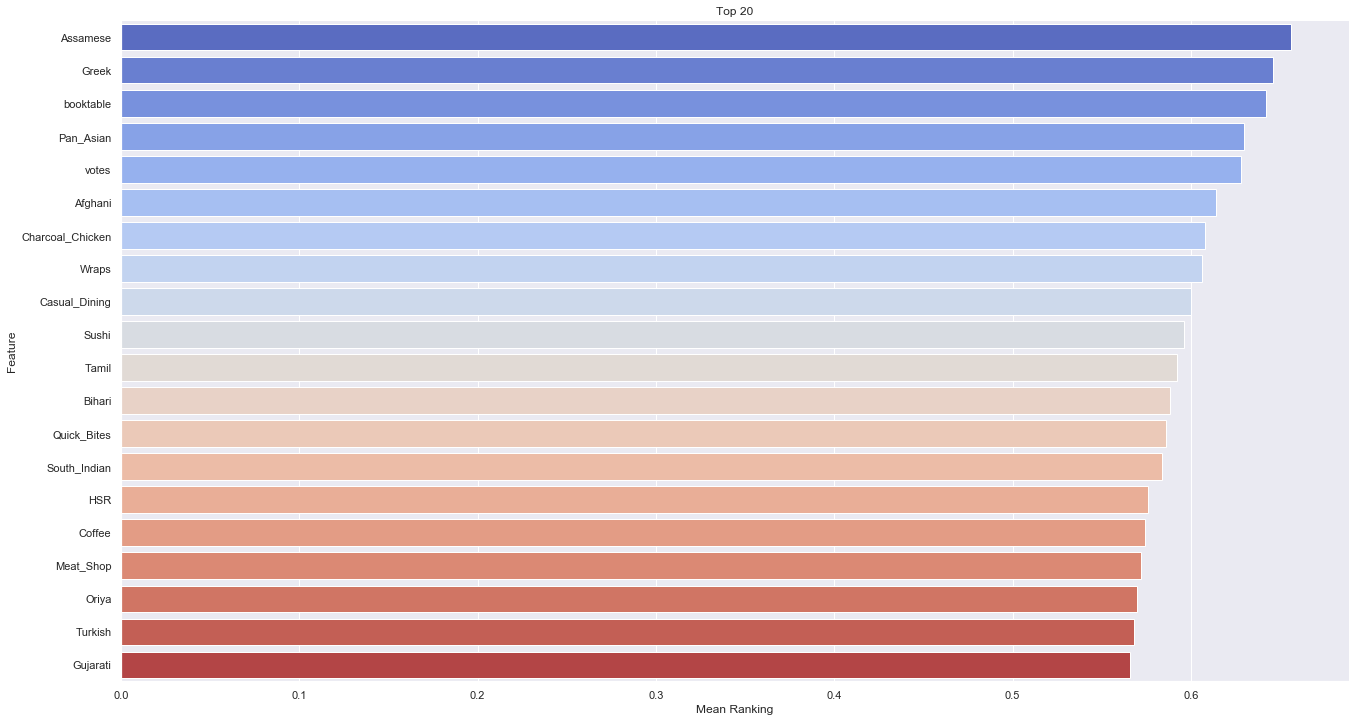

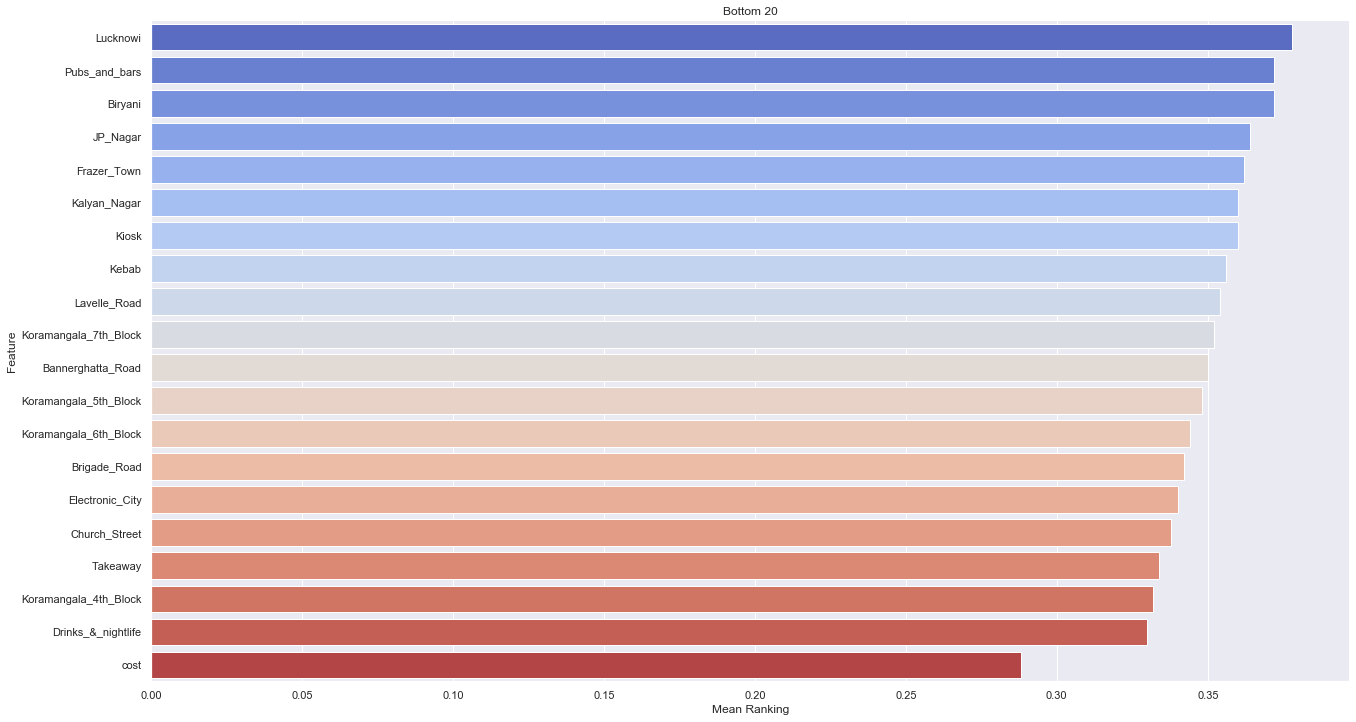

In [62]:
def drawgraph(data,gph_columns):
    sns.catplot(x=gph_columns[1], y=gph_columns[0], data = data[:20], kind="bar",height=10, aspect=1.9, palette='coolwarm')
    plt.title("Top 20")
    sns.catplot(x=gph_columns[1], y=gph_columns[0], data = data[-20:], kind="bar",height=10, aspect=1.9, palette='coolwarm')
    plt.title("Bottom 20")
    
    
def testattributes(X,y):
    ranks = {}
    name  = ['LinearRegression', 'RFE', 'Ridge', 'Lasso', 'RandomForestRegressor']
    for i in range(len(model)):
        if name[i] == 'RFE':
            ranks[name[i]] =  drawranking(list(map(float, model[i].ranking_)), feature_cols, order=-1)
        elif name[i] == 'RandomForestRegressor':
            ranks[name[i]] =  drawranking(model[i].feature_importances_, feature_cols)
        else:
            ranks[name[i]] =  drawranking(list(map(float, model[i].coef_)), feature_cols)
   
    mean_scores = {}
    for i in feature_cols:
        mean_scores[i] = round(np.mean([ranks[method][i] for method in ranks.keys()]), 4)

    gph_columns = ['Feature','Mean Ranking']
    data = pd.DataFrame(list(mean_scores.items()), columns=gph_columns).sort_values(gph_columns[1], ascending=False)
    drawgraph(data,gph_columns)
    return data
meanplot = testattributes(X,y)

In [63]:
from xgboost import plot_importance

def xgaimportancefilter(X,y):
    model = XGBClassifier()
    model.fit(X, y)
    plt.figure(figsize=(10,10))
    plot_importance(model)
    plt.show()

In [64]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [65]:
modelNB = GaussianNB()
rfc = RandomForestClassifier(n_estimators=50)
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
xgb = XGBClassifier()


# svc = SVC(kernel='poly')# as data supposely not in linear format

models = [modelNB, rfc, mlp, xgb]
modelNames = ['GaussianNB','RandomForest', 'MLPC', 'XGBClassifier']

In [66]:
def getModelScores():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(modelNames[models.index(model)]," Accuracy:",accuracy_score(y_test, y_pred)) 

In [67]:
to_drop = meanplot[meanplot['Mean Ranking'] <= 0.35]['Feature'].tolist()
df2 = df[:]
df2 = df.drop(to_drop, axis=1)

In [68]:
cols = list(df2)
feature_cols = cols[:len(cols)-1]
X = df2[feature_cols] # Features
y = df2.rating # Target variable

In [69]:
getModelScores()

GaussianNB  Accuracy: 0.36331521739130435
RandomForest  Accuracy: 0.7989130434782609
MLPC  Accuracy: 0.7559782608695652
XGBClassifier  Accuracy: 0.7934782608695652


In [ ]:
# xgaimportancefilter(X,y)

In [70]:
cols = list(df)
feature_cols = cols[:len(cols)-1]
X = df[feature_cols] # Features
y = df.rating # Target variable

In [71]:
getModelScores()

GaussianNB  Accuracy: 0.36467391304347824
RandomForest  Accuracy: 0.8255434782608696
MLPC  Accuracy: 0.7758152173913043
XGBClassifier  Accuracy: 0.8002717391304348


In [72]:
# xgaimportancefilter

In [73]:
df_temp2 = df[:]
d_rate2 = resample(df[df['rating'] == 2], replace=False, n_samples=87, random_state=123)
d_rate3 = resample(df[df['rating'] == 3], replace=False, n_samples=87, random_state=123)
d_rate1 = resample(df[df['rating'] == 1], replace=False, n_samples=87, random_state=123)
d_rate0 = resample(df[df['rating'] == 0], replace=False, n_samples=87, random_state=123)
df_sampled = pd.concat([d_rate0,d_rate1,d_rate2,d_rate3])

In [74]:
cols = list(df_sampled)
feature_cols = cols[:len(cols)-1]
X = df_sampled[feature_cols] # Features
y = df_sampled.rating # Target variable

In [75]:
getModelScores()

GaussianNB  Accuracy: 0.37142857142857144
RandomForest  Accuracy: 0.7142857142857143
MLPC  Accuracy: 0.4714285714285714
XGBClassifier  Accuracy: 0.7142857142857143


In [76]:
xgaimportancefilter

<function __main__.xgaimportancefilter(X, y)>

In [ ]:
#https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
#stackoverflow.com/